<a href="https://colab.research.google.com/github/belovelace/AI-study/blob/main/UCI_HAR_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 3층 LSTM 아키텍처 구축 (64-128-64 유닛)
- BatchNormalization으로 학습 안정화
- EarlyStopping patience를 20으로 증가 (LSTM 수렴 시간 고려)
- RNN vs LSTM 성능 비교 그래프 추가
- 예상 정확도: 85-92% (RNN 74% 대비 개선)

LSTM의 장점:
- 장기 의존성 학습 능력 향상
- Vanishing Gradient 문제 해결
- 복잡한 시계열 패턴 포착

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Input, Conv1D, BatchNormalization,
    ReLU, MaxPooling1D, GlobalAveragePooling1D, SimpleRNN,
    LSTM # Import LSTM layer
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

TRAIN = "train/"
TEST = "test/"
DATASET_PATH = "/content/drive/MyDrive/AI_study/UCI HAR Dataset/"

# X 데이터 로드 함수
def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        series_list = []

        with open(signal_type_path, 'r') as file:
            for row in file:
                row_clean = row.replace('  ', ' ')
                row_clean = row_clean.strip()
                serie = row_clean.split(' ')
                serie_array = np.array(serie, dtype=np.float32)
                series_list.append(serie_array)

        X_signals.append(series_list)

    X_signals = np.array(X_signals)
    return np.transpose(X_signals, (1, 2, 0))

# y 레이블 로드 함수
def load_y(y_path):
    with open(y_path, 'r') as file:
        labels = [int(line.strip()) for line in file]
    return np.array(labels, dtype=np.int32) - 1  # 0부터 시작하도록

# X 데이터 로드
X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt"
    for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt"
    for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

# y 레이블 로드
y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("="*60)
print("데이터 로딩 완료")
print("="*60)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"\n첫 5개 레이블: {y_train[:5]}")

Mounted at /content/drive
데이터 로딩 완료
X_train shape: (7352, 128, 9)
X_test shape: (2947, 128, 9)
y_train shape: (7352,)
y_test shape: (2947,)

첫 5개 레이블: [4 4 4 4 4]


### LSTM 모델 구축

In [3]:
print("\n" + "="*60)
print("LSTM 모델 구축")
print("="*60)

input_shape = (X_train.shape[1], X_train.shape[2])  # (128, 9)
num_classes = 6

lstm_model = Sequential([
    Input(shape=input_shape),

    # LSTM 레이어 1 - 장기 의존성 학습
    LSTM(64, return_sequences=True),
    BatchNormalization(),  # 학습 안정화
    Dropout(0.3),

    # LSTM 레이어 2 - 더 깊은 특징 추출
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    # LSTM 레이어 3 - 최종 시퀀스 처리
    LSTM(64),
    BatchNormalization(),
    Dropout(0.3),

    # 완전연결층
    Dense(64, activation='relu'),
    Dropout(0.2),

    # 출력층
    Dense(num_classes, activation='softmax')
], name='LSTM_Model')

# 모델 컴파일 - 학습률 조정
lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),  # 학습률 명시
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

print("\nLSTM 모델 구조:")
lstm_model.summary()


LSTM 모델 구축

LSTM 모델 구조:


Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128, 64)        │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 172,742 (674.77 KB)

 Trainable params: 172,230 (672.77 KB)

 Non-trainable params: 512 (2.00 KB)

### 콜백 설정

In [4]:
print("\n" + "="*60)
print("콜백 함수 설정")
print("="*60)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,  # LSTM은 더 오래 학습 필요
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_lstm_model.h5',
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks = [early_stopping, reduce_lr, checkpoint]

print("✓ EarlyStopping: patience=20 (RNN보다 길게)")
print("✓ ReduceLROnPlateau: patience=10")
print("✓ ModelCheckpoint: 최고 성능 모델 저장")


콜백 함수 설정
✓ EarlyStopping: patience=20 (RNN보다 길게)
✓ ReduceLROnPlateau: patience=10
✓ ModelCheckpoint: 최고 성능 모델 저장


### 모델 학습

In [5]:
print("\n" + "="*60)
print("LSTM 모델 학습 시작")
print("="*60)
print("LSTM은 RNN보다 느리지만 성능이 훨씬 좋습니다!")
print("="*60)

batch_size = 64
epochs = 100

history = lstm_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)


LSTM 모델 학습 시작
LSTM은 RNN보다 느리지만 성능이 훨씬 좋습니다!
Epoch 1/100
113/115 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.0086 - sparse_categorical_accuracy: 0.6285
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.45097, saving model to best_lstm_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - loss: 0.9998 - sparse_categorical_accuracy: 0.6317 - val_loss: 1.5158 - val_sparse_categorical_accuracy: 0.4510 - learning_rate: 0.0010
Epoch 2/100
113/115 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2831 - sparse_categorical_accuracy: 0.9037
Epoch 2: val_sparse_categorical_accuracy improved from 0.45097 to 0.50763, saving model to best_lstm_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.2820 - sparse_categorical_accuracy: 0.9040 - val_loss: 2.0336 - val_sparse_categorical_accuracy: 0.5076 - learning_rate: 0.0010
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1662 - sparse_categorical_accuracy: 0.9406
Epoch 3: val_sparse_categorical_accuracy improved from 0.50763 to 0.78962, saving model to best_lstm_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.1662 - sparse_categorical_accuracy: 0.9406 - val_loss: 0.7452 - val_sparse_categorical_accuracy: 0.7896 - learning_rate: 0.0010
Epoch 4/100
114/115 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1806 - sparse_categorical_accuracy: 0.9311
Epoch 4: val_sparse_categorical_accuracy improved from 0.78962 to 0.85714, saving model to best_lstm_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1804 - sparse_categorical_accuracy: 0.9311 - val_loss: 0.6226 - val_sparse_categorical_accuracy: 0.8571 - learning_rate: 0.0010
Epoch 5/100
114/115 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1542 - sparse_categorical_accuracy: 0.9384
Epoch 5: val_sparse_categorical_accuracy improved from 0.85714 to 0.89956, saving model to best_lstm_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.1540 - sparse_categorical_accuracy: 0.9384 - val_loss: 0.2884 - val_sparse_categorical_accuracy: 0.8996 - learning_rate: 0.0010
Epoch 6/100
114/115 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1686 - sparse_categorical_accuracy: 0.9337
Epoch 6: val_sparse_categorical_accuracy did not improve from 0.89956
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.1690 - sparse_categorical_accuracy: 0.9335 - val_loss: 0.5110 - val_sparse_categorical_accuracy: 0.7723 - learning_rate: 0.0010
Epoch 7/100
113/115 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1525 - sparse_categorical_accuracy: 0.9429
Epoch 7: val_sparse_categorical_accuracy improved from 0.89956 to 0.91924, saving model to best_lstm_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.1525 - sparse_categorical_accuracy: 0.9429 - val_loss: 0.2405 - val_sparse_categorical_accuracy: 0.9192 - learning_rate: 0.0010
Epoch 8/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1241 - sparse_categorical_accuracy: 0.9497
Epoch 8: val_sparse_categorical_accuracy did not improve from 0.91924
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1241 - sparse_categorical_accuracy: 0.9497 - val_loss: 0.2232 - val_sparse_categorical_accuracy: 0.9043 - learning_rate: 0.0010
Epoch 9/100
113/115 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1313 - sparse_categorical_accuracy: 0.9513
Epoch 9: val_sparse_categorical_accuracy did not improve from 0.91924
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1313 - sparse_categorical_accuracy: 0.9512 - val_loss: 0.2615 - val_sparse_categorical_accuracy: 0.8948 - learning_rate: 0.0010
Epoch 10/100
114/115 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1415 - sparse_categorical_accuracy: 0.940

115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.1153 - sparse_categorical_accuracy: 0.9531 - val_loss: 0.3139 - val_sparse_categorical_accuracy: 0.9237 - learning_rate: 0.0010
Epoch 17/100
114/115 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1100 - sparse_categorical_accuracy: 0.9522
Epoch 17: val_sparse_categorical_accuracy did not improve from 0.92365
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1103 - sparse_categorical_accuracy: 0.9521 - val_loss: 0.3314 - val_sparse_categorical_accuracy: 0.9023 - learning_rate: 0.0010
Epoch 18/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1162 - sparse_categorical_accuracy: 0.9586
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 18: val_sparse_categorical_accuracy did not improve from 0.92365
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1162 - sparse_categorical_accuracy: 0.9585 - val_loss: 0.3894 - val_sparse_categorical_accuracy: 0.9013 - learning_rate: 0.0010
Epoch 19/100
113/115 ━━━

115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0933 - sparse_categorical_accuracy: 0.9579 - val_loss: 0.3550 - val_sparse_categorical_accuracy: 0.9250 - learning_rate: 5.0000e-04
Epoch 27/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1000 - sparse_categorical_accuracy: 0.9586
Epoch 27: val_sparse_categorical_accuracy did not improve from 0.92501
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.1001 - sparse_categorical_accuracy: 0.9586 - val_loss: 0.3261 - val_sparse_categorical_accuracy: 0.9182 - learning_rate: 5.0000e-04
Epoch 28/100
113/115 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0999 - sparse_categorical_accuracy: 0.9549
Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 28: val_sparse_categorical_accuracy did not improve from 0.92501
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0999 - sparse_categorical_accuracy: 0.9549 - val_loss: 0.3480 - val_sparse_categorical_accuracy: 0.9209 - learning_rate: 5.0000e-04
Epoch 28: ea

### 모델 평가

In [6]:
print("\n" + "="*60)
print("LSTM 모델 평가")
print("="*60)

# 테스트 데이터 평가
test_loss, test_acc = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"\n✓ Test Accuracy: {test_acc*100:.2f}%")
print(f"✓ Test Loss: {test_loss:.4f}")

# 훈련 데이터 평가
train_loss, train_acc = lstm_model.evaluate(X_train, y_train, verbose=0)
print(f"✓ Train Accuracy: {train_acc*100:.2f}%")
print(f"✓ Train Loss: {train_loss:.4f}")

# RNN과 비교
print(f"\n성능 개선:")
print(f"  RNN Test Accuracy:  74.04%")
print(f"  LSTM Test Accuracy: {test_acc*100:.2f}%")
print(f"  개선율: +{(test_acc*100 - 74.04):.2f}%p")


LSTM 모델 평가

✓ Test Accuracy: 90.43%
✓ Test Loss: 0.2232
✓ Train Accuracy: 94.34%
✓ Train Loss: 0.1239

성능 개선:
  RNN Test Accuracy:  74.04%
  LSTM Test Accuracy: 90.43%
  개선율: +16.39%p


### 예측 및 분류 리포트

In [8]:
print("\n" + "="*60)
print("상세 분류 리포트")
print("="*60)

y_pred = lstm_model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\n Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=LABELS))


상세 분류 리포트

 Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.99      0.95      0.97       496
  WALKING_UPSTAIRS       0.97      0.94      0.95       471
WALKING_DOWNSTAIRS       0.93      0.99      0.96       420
           SITTING       0.72      0.86      0.78       491
          STANDING       0.85      0.71      0.77       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.90      2947
         macro avg       0.91      0.91      0.91      2947
      weighted avg       0.91      0.90      0.90      2947



### 혼동 행렬 시각화


혼동 행렬 생성


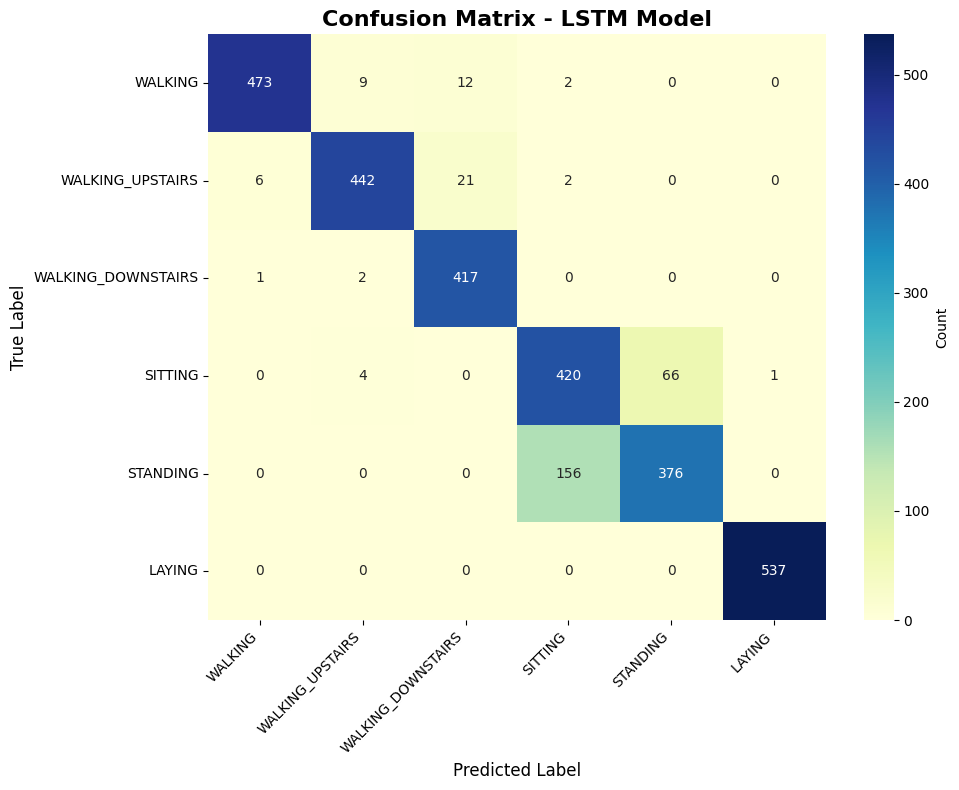

✓ 혼동 행렬 생성 완료


In [10]:
print("\n" + "="*60)
print("혼동 행렬 생성")
print("="*60)

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=LABELS, yticklabels=LABELS,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - LSTM Model', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("✓ 혼동 행렬 생성 완료")

### 학습 과정 시각화


학습 과정 시각화


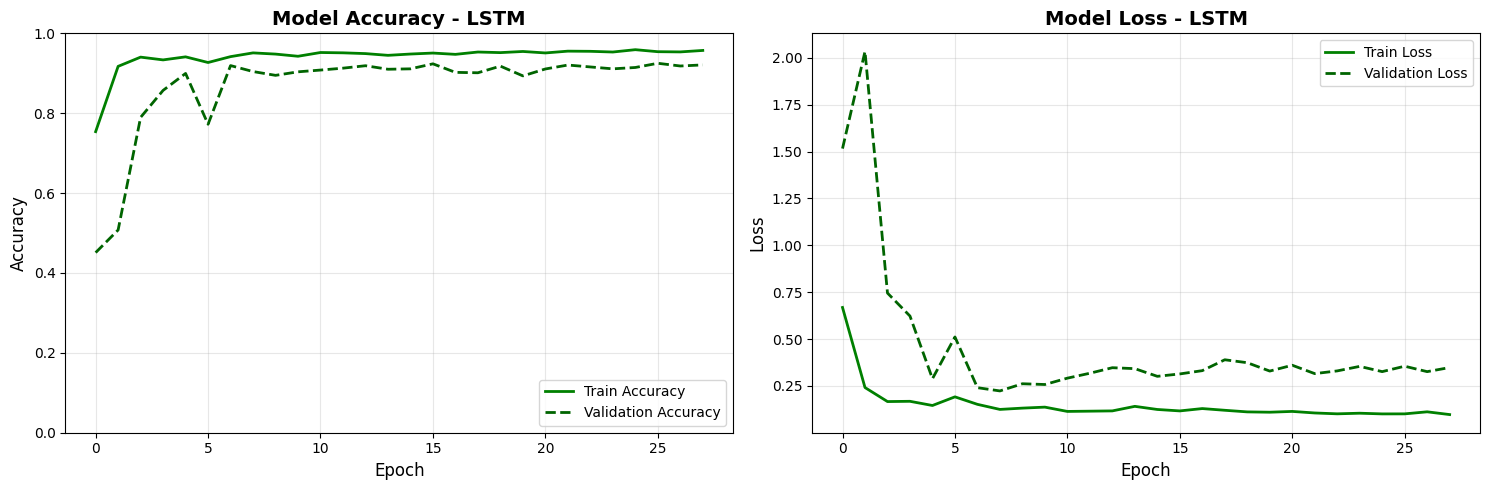

✓ 학습 과정 그래프 생성 완료


In [9]:
print("\n" + "="*60)
print("학습 과정 시각화")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy 그래프
axes[0].plot(history.history['sparse_categorical_accuracy'],
             label='Train Accuracy', linewidth=2, color='green')
axes[0].plot(history.history['val_sparse_categorical_accuracy'],
             label='Validation Accuracy', linewidth=2, linestyle='--', color='darkgreen')
axes[0].set_title('Model Accuracy - LSTM', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# Loss 그래프
axes[1].plot(history.history['loss'],
             label='Train Loss', linewidth=2, color='green')
axes[1].plot(history.history['val_loss'],
             label='Validation Loss', linewidth=2, linestyle='--', color='darkgreen')
axes[1].set_title('Model Loss - LSTM', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ 학습 과정 그래프 생성 완료")

### 클래스별 정확도 분석


클래스별 정확도 분석
WALKING             :  95.36%
WALKING_UPSTAIRS    :  93.84%
WALKING_DOWNSTAIRS  :  99.29%
SITTING             :  85.54%
STANDING            :  70.68%
LAYING              : 100.00%


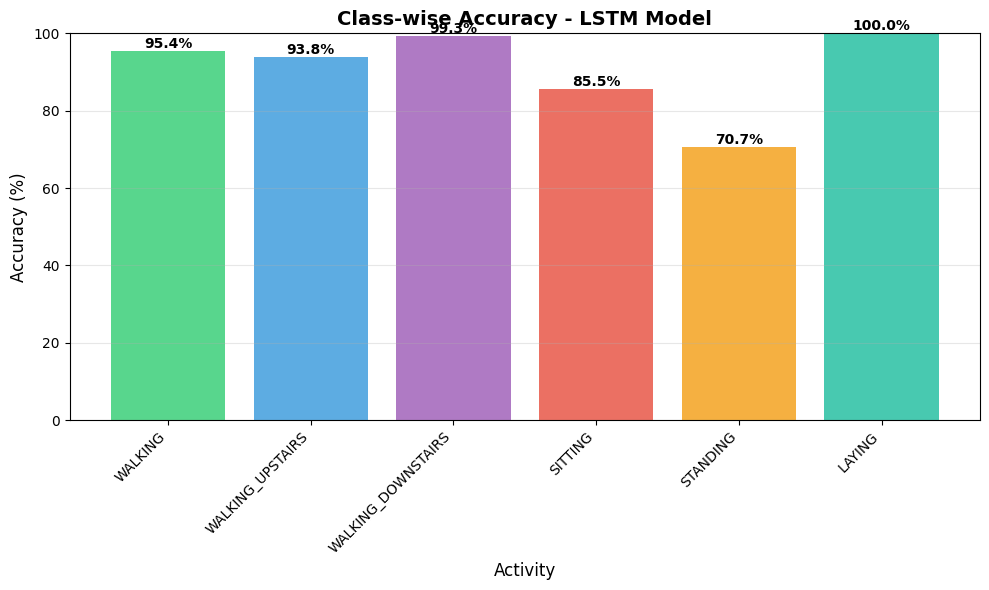

✓ 클래스별 정확도 그래프 생성 완료


In [11]:
print("\n" + "="*60)
print("클래스별 정확도 분석")
print("="*60)

class_accuracy = []
for i in range(num_classes):
    mask = y_test == i
    if mask.sum() > 0:
        acc = (y_pred_classes[mask] == y_test[mask]).mean()
        class_accuracy.append(acc)
        print(f"{LABELS[i]:20s}: {acc*100:6.2f}%")

# 클래스별 정확도 막대 그래프
plt.figure(figsize=(10, 6))
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12', '#1abc9c']
bars = plt.bar(LABELS, [acc*100 for acc in class_accuracy], color=colors, alpha=0.8)
plt.title('Class-wise Accuracy - LSTM Model', fontsize=14, fontweight='bold')
plt.xlabel('Activity', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 100])
plt.grid(True, alpha=0.3, axis='y')

# 막대 위에 정확도 표시
for bar, acc in zip(bars, class_accuracy):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc*100:.1f}%',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ 클래스별 정확도 그래프 생성 완료")

### 예측 샘플 확인

In [12]:
print("\n" + "="*60)
print("예측 샘플 확인 (처음 10개)")
print("="*60)

for i in range(10):
    true_label = y_test[i]
    pred_label = y_pred_classes[i]
    confidence = y_pred[i][pred_label] * 100

    status = "✓" if true_label == pred_label else "✗"

    print(f"\n샘플 {i+1:2d}: {status}")
    print(f"  실제: {LABELS[true_label]:20s}")
    print(f"  예측: {LABELS[pred_label]:20s} (확신도: {confidence:5.1f}%)")


예측 샘플 확인 (처음 10개)

샘플  1: ✓
  실제: STANDING            
  예측: STANDING             (확신도:  95.7%)

샘플  2: ✓
  실제: STANDING            
  예측: STANDING             (확신도:  95.5%)

샘플  3: ✓
  실제: STANDING            
  예측: STANDING             (확신도:  95.6%)

샘플  4: ✓
  실제: STANDING            
  예측: STANDING             (확신도:  95.6%)

샘플  5: ✓
  실제: STANDING            
  예측: STANDING             (확신도:  95.5%)

샘플  6: ✓
  실제: STANDING            
  예측: STANDING             (확신도:  95.5%)

샘플  7: ✓
  실제: STANDING            
  예측: STANDING             (확신도:  95.5%)

샘플  8: ✓
  실제: STANDING            
  예측: STANDING             (확신도:  95.4%)

샘플  9: ✓
  실제: STANDING            
  예측: STANDING             (확신도:  95.4%)

샘플 10: ✓
  실제: STANDING            
  예측: STANDING             (확신도:  95.5%)


### 최종 요약

In [13]:
print("\n" + "="*60)
print("LSTM 모델 학습 완료!")
print("="*60)
print(f"최종 테스트 정확도: {test_acc*100:.2f}%")
print(f"RNN 대비 개선율: +{(test_acc*100 - 74.04):.2f}%p")
print(f"총 에포크: {len(history.history['loss'])}")
print(f"모델 저장: best_lstm_model.h5")
print("="*60)
print("\n LSTM의 장점:")
print("  ✓ 장기 의존성(Long-term dependency) 학습 가능")
print("  ✓ Vanishing Gradient 문제 해결")
print("  ✓ 더 복잡한 시계열 패턴 포착")
print("="*60)


LSTM 모델 학습 완료!
최종 테스트 정확도: 90.43%
RNN 대비 개선율: +16.39%p
총 에포크: 28
모델 저장: best_lstm_model.h5

 LSTM의 장점:
  ✓ 장기 의존성(Long-term dependency) 학습 가능
  ✓ Vanishing Gradient 문제 해결
  ✓ 더 복잡한 시계열 패턴 포착
